# Image Denoising with Autoencoders

## Importing Libraries
___
We will be using the MNIST dataset which contains 10k images of 0-9 of size 28x28
___

In [1]:
import numpy as np

from tensorflow.keras.datasets import mnist
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback
from tensorflow.keras.utils import to_categorical

%matplotlib inline

## Data Preprocessing
___
Splitting the dataset into train and test data
___

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float')/255.
x_test = x_test.astype('float')/255.

x_train = np.reshape(x_train, (60000, 784))
x_test = np.reshape(x_test, (10000, 784))

## Adding Noise
___
We have a clean dataset from MNIST. We will add noise to it and see whether our model can reverse engineer that and give us denoised images.
___

In [3]:
x_train_noisy = x_train + np.random.rand(60000, 784) * 0.9
x_test_noisy = x_test + np.random.rand(10000, 784) * 0.9

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

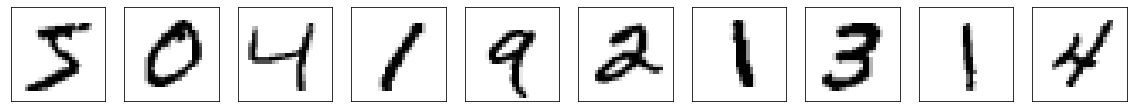

In [4]:
def plot(x, p, labels = False):
    plt.figure(figsize=(20,2))
    for i in range(10):
        plt.subplot(1,10,i+1)
        plt.imshow(x[i].reshape(28,28), cmap='binary')
        plt.xticks([])
        plt.yticks([])
        if labels:
            plt.xlabel(np.argmax(p[i]))
    plt.show()
    return
plot(x_train, None)

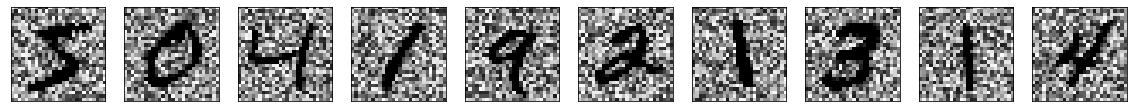

In [5]:
plot(x_train_noisy, None)

## Building and Training a Classifier
___
First  we will build and train a classifier for detecting the numbers in the images correctly
___

In [6]:
classifier = Sequential([
    Dense(256, activation='relu', input_shape=(784,)),
    Dense(256, activation='relu'),
    Dense(10, activation='softmax')
])

classifier.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
classifier.fit(x_train, y_train, epochs=3, batch_size=512)

Train on 60000 samples
Epoch 1/3
60000/60000 [==============================] - 3s 47us/sample - loss: 0.4255 - accuracy: 0.8837
Epoch 2/3
60000/60000 [==============================] - 3s 49us/sample - loss: 0.1534 - accuracy: 0.9559
Epoch 3/3
60000/60000 [==============================] - 3s 50us/sample - loss: 0.1060 - accuracy: 0.9693


In [7]:
loss, acc = classifier.evaluate(x_test, y_test)
print(acc)

10000/10000 [==============================] - 2s 170us/sample - loss: 0.1007 - accuracy: 0.9692
0.9692


In [8]:
loss, acc = classifier.evaluate(x_test_noisy, y_test)
print(acc)

10000/10000 [==============================] - 1s 150us/sample - loss: 7.7709 - accuracy: 0.2042
0.2042


## Building the Autoencoder
___
This part is where we build a model that can denoise images 
___

In [9]:
input_image = Input(shape=(784,))
encoded = Dense(64, activation='relu')(input_image)
decoded = Dense(784, activation='sigmoid')(encoded)

autoencoder = Model(input_image, decoded)
autoencoder.compile(loss='binary_crossentropy', optimizer='adam')

## Training the Autoencoder
___
Training the autoencoder model on the noisy 'train' data and reducing the loss value
___

In [10]:
autoencoder.fit(
    x_train_noisy, x_train,
    epochs=100, batch_size=512,
    validation_split=0.2, verbose=False,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5),
        LambdaCallback(on_epoch_end=lambda e,l: print('{:.3f}'.format(l['val_loss']), end=' _ '))
    ]
)

print(' _ ')
print('Training is complete!')

0.259 _ 0.229 _ 0.196 _ 0.176 _ 0.164 _ 0.155 _ 0.148 _ 0.142 _ 0.137 _ 0.133 _ 0.129 _ 0.126 _ 0.123 _ 0.121 _ 0.119 _ 0.117 _ 0.116 _ 0.114 _ 0.113 _ 0.112 _ 0.111 _ 0.110 _ 0.109 _ 0.108 _ 0.108 _ 0.107 _ 0.107 _ 0.106 _ 0.106 _ 0.105 _ 0.105 _ 0.105 _ 0.104 _ 0.104 _ 0.104 _ 0.104 _ 0.104 _ 0.103 _ 0.103 _ 0.103 _ 0.103 _ 0.103 _ 0.103 _ 0.103 _ 0.103 _ 0.103 _ 0.103 _ 0.103 _ 0.103 _ 0.102 _ 0.102 _ 0.102 _ 0.102 _ 0.102 _ 0.102 _ 0.102 _ 0.102 _ 0.102 _ 0.102 _ 0.102 _ 0.102 _ 0.102 _ 0.102 _ 0.102 _ 0.102 _ 0.102 _ 0.102 _ 0.102 _ 0.102 _ 0.102 _ 0.102 _ 0.102 _ 0.102 _ 0.102 _ 0.102 _ 0.102 _ 0.102 _ 0.102 _ 0.102 _ 0.102 _ 0.102 _ 0.102 _ 0.102 _ 0.102 _ 0.102 _ 0.102 _ 0.102 _ 0.102 _ 0.102 _ 0.102 _ 0.102 _ 0.102 _ 0.102 _ 0.102 _ 0.102 _  _ 
Training is complete!


## Denoised Images
___
Putting the autoencoder to use, we denoise the images
___

In [11]:
preds = autoencoder.predict(x_test_noisy)

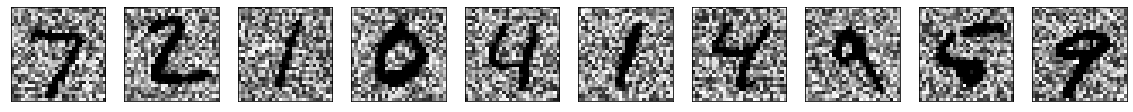

In [12]:
plot(x_test_noisy, None)

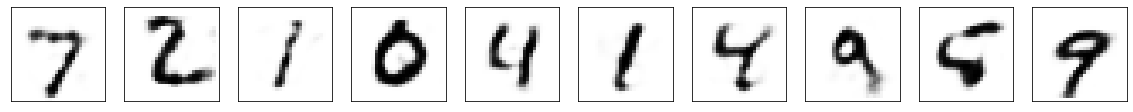

In [13]:
plot(preds, None)

In [14]:
loss, acc = classifier.evaluate(preds, y_test)
print(acc)

10000/10000 [==============================] - 2s 160us/sample - loss: 0.1600 - accuracy: 0.9529
0.9529


## Composite Model
___
Till now, we built two different models. One for image recognition, one for denoising the images. Now we combine both the models to create one single model that can both denoise images and recognise the number in it, at the same time
___

In [15]:
input_image=Input(shape=(784,))
x=autoencoder(input_image)
y=classifier(x)

denoise_and_classfiy = Model(input_image, y)

In [16]:
predictions=denoise_and_classfiy.predict(x_test_noisy)

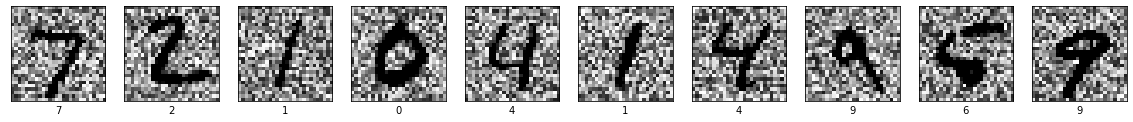

In [17]:
plot(x_test_noisy, predictions, True)

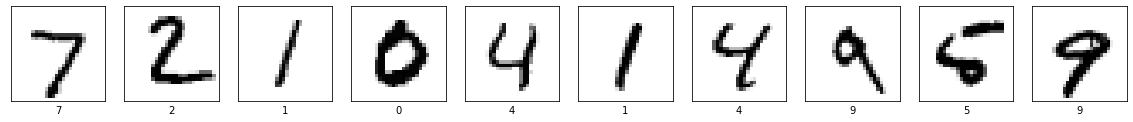

In [18]:
plot(x_test, to_categorical(y_test), True)